# Klasyfikacja raka mózgu - Hubert Jaremko

## Modele klasyczne

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import np_utils

### Ustawienia

In [2]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki'}

In [3]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
# image_size = (64, 64)
image_size = (32, 32)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

In [4]:
def generator_to_array(data_generator):
    data_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        data = data_generator.next()
        data_list.append(data[0])
        batch_index = batch_index + 1

    data_array = np.asarray(data_list, dtype=object)
    X = np.concatenate(data_array, axis=0)
    y = data_generator.classes
    y = np_utils.to_categorical(y)
    return (X, y)

In [5]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 7))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])
        plt.legend()

In [6]:
def plot_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(6, 5))
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu")
    plt.show()

In [7]:
target = ['Oponiak', 'Glejak', 'Guz przysadki']

def binarize_labels(y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return y_test

def multiclass_roc_auc_score(y_test, y_pred, c_ax, average="macro"):
    y_test = binarize_labels(y_test)
#     y_pred = binarize_labels(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})')

    c_ax.plot(fpr, fpr, '--', color = '0.75', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred):
    fig, c_ax = plt.subplots(1, 1, figsize = (5, 3))

    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_ax))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

## Wczytanie zbioru testowego i walidacyjnego

In [8]:
from os import walk
from PIL import Image

def read_brains(data, source, filenames, t):
    for filename in filenames:
        image = Image.open(f'data/{source}/{t}/{filename}').convert('L')
        img = np.array(image)
        data.append((img, t))

In [9]:
# brains_data = []

# _, _, type_1_filenames = next(walk('data/train/1/'))
# _, _, type_2_filenames = next(walk('data/train/2/'))
# _, _, type_3_filenames = next(walk('data/train/3/'))
# read_brains(brains_data, 'train', type_1_filenames, 1)
# read_brains(brains_data, 'train', type_2_filenames, 2)
# read_brains(brains_data, 'train', type_3_filenames, 3)

In [10]:
def read_brain_dir(directory):
    brains_data = []

    _, _, type_1_filenames = next(walk(f'data/{directory}/1/'))
    _, _, type_2_filenames = next(walk(f'data/{directory}/2/'))
    _, _, type_3_filenames = next(walk(f'data/{directory}/3/'))
    read_brains(brains_data, directory, type_1_filenames, 1)
    read_brains(brains_data, directory, type_2_filenames, 2)
    read_brains(brains_data, directory, type_3_filenames, 3)
    
    return brains_data

In [11]:
def raw_brain_data_to_dataframe(directory):
    raw = read_brain_dir(directory)
    return pd.DataFrame(data=raw, columns=['image', 'tumor_class'])

In [12]:
train_df = raw_brain_data_to_dataframe('train')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        3678 non-null   object
 1   tumor_class  3678 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.6+ KB


In [13]:
# X_train / 255.

In [14]:
test_df = raw_brain_data_to_dataframe('val')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        600 non-null    object
 1   tumor_class  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [15]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(df):
    X = df.drop(['tumor_class'], axis=1)
    y = df['tumor_class'].values

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    print("X.shape: {} y.shape: {}".format(X.shape, y.shape))
    return (X, y)

In [29]:
X_train, y_train = encode_labels(train_df)

X.shape: (3678, 1) y.shape: (3678,)


In [ ]:
X_test, y_test = encode_labels(test_df)

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

from skimage.transform import resize

class Flattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
#         arr = np.array([resize(x, image_size) for x in X['image'].values])
        arr = np.array([resize(x, image_size) for x in X['image'].values])
        return arr.reshape((-1, image_size[0] * image_size[1]))
    
class Normalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X / 255.

In [18]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        # ("augment_images", Augmenter()),
        ("flatten_image", Flattener()),
#         ("normalize", Normalizer()),
    ])

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# train_generator = ImageDataGenerator(
#     horizontal_flip=True,
# #     vertical_flip=True,
#     brightness_range=(0.8, 1.5)
# #     brightness_range=(1.0, 2.0)
# )

# def get_train_generator():
#     return train_generator.flow_from_directory(
#             train_dir,
#             target_size=image_size,
#             batch_size=batch_size,
#             class_mode='categorical',
#             shuffle=True)

# train_data_generator = get_train_generator()
# train_steps_per_epoch = np.math.ceil(train_data_generator.samples / train_data_generator.batch_size)

In [21]:
# test_generator = ImageDataGenerator()

# def get_test_generator():
#     return test_generator.flow_from_directory(
#             val_dir,
#             target_size=image_size,
#             batch_size=batch_size,
#             class_mode='categorical',
#             shuffle=False)

# test_data_generator = get_test_generator()
# test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

### Próbka zbioru treningowego

In [23]:
# plt.figure(figsize=(10, 10))

# b = next(train_data_generator)

# images = b[0]
# labels = b[1]

# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     image = images[i]
#     label = labels[i]
#     plt.imshow(image.astype("uint8"))
#     label = cancer_type[np.argmax(label)]
#     plt.title(label)
    
# train_data_generator = get_train_generator()

## Modele

In [24]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy.stats.distributions import uniform, randint

In [ ]:
# X_train, y_train = generator_to_array(get_train_generator())
# X_test, y_test = generator_to_array(get_test_generator())

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# yy_train = np.argmax(y_train, axis=1)
# yy_test = np.argmax(y_test, axis=1)
# label_encoder = LabelEncoder()
# yy_train = label_encoder.fit_transform(yy_train)
# yy_test = label_encoder.fit_transform(yy_test)

In [ ]:
# XX_train = X_train.reshape(-1, image_size[0] * image_size[1] * 3)
# XX_test = X_test.reshape(-1, image_size[0] * image_size[1] * 3)

In [ ]:
# print("X.shape: {}\ny.shape: {}".format(XX_train.shape, yy_train.shape))

In [25]:
seed=123
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
# from sklearn.utils import class_weight

# y_ints = [y.argmax() for y in y_train]
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_ints), y=y_ints)
# class_weights = dict(enumerate(class_weights))
# class_weights

### SVC linear

In [26]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='rbf', probability=True, verbose=True))])


param_grid = {
            # 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
            'classifier__C': [0.01]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise')
# grid_1 = GridSearchCV(pipe, param_grid, cv=kfold)

# grid_1.fit(XX_train, yy_train)
# grid_1.fit(X_train, y_train)
# grid_1.best_params_

In [27]:
# X_train = Normalizer().fit_transform(X_train)
# y_train = Normalizer().fit_transform(y_train)

In [30]:
pipe.fit(X_train, y_train)

[LibSVM]

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('flatten_image',
                                                 Flattener())])),
                ('classifier', SVC(probability=True, verbose=True))])

In [ ]:
y_train

In [31]:
models = []

# models.append(('svm_rbf', grid_1.best_estimator_))
models.append(('svm_rbf', pipe))

In [32]:
predictions = {}

for name, model in models:
#     predictions[name] = (model.predict_proba(XX_test), model.predict(XX_test))
#     predictions[name] = (model.predict_proba(X_test), model.predict(X_test))
    probas = model.predict_proba(X_test);
    predictions[name] = (probas, np.argmax(probas, axis=1))
#     predictions[name] = ([], model.predict(X_train))
    print(f'{name} done.')
#     

svm_rbf done.


svm_rbf
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       200
           1       0.83      0.90      0.86       200
           2       0.94      0.98      0.96       200

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



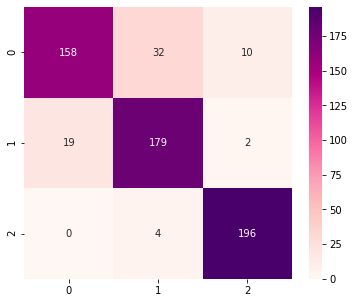

ROC AUC score: 0.9726083333333332


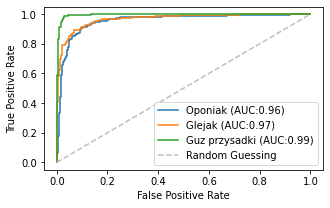

In [33]:
for name, model in models:
    print(name)
    true_classes = y_test
    predicted_probas, predicted_classes = predictions[name]

    report = metrics.classification_report(true_classes, predicted_classes)

    print(report)
    plot_confusion_matrix(predicted_classes, true_classes)   
    plot_roc_curve(true_classes, predicted_probas)

In [ ]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [ ]:
img = keras.preprocessing.image.load_img(
    "data/val/3/13.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# print(X_train.shape)

p = model.predict_proba(img_array)
score = p[0]
print(score)
print_proba(score, 0)
print_proba(score, 1)
print_proba(score, 2)